# Text search/indexing using prime number factorisation
---
## Abstract
This report details the proof of concept for using prime numbers for indexing text with the intention of searching for words within a data set. This technique is shown to significantly out perform regular string comparison in all the aspect that were tested i.e number of records, lengths of records, length of dictionary, and number of words searched for. 

The targeted use case for this algorithm is in exploratory text analysis by finding the frequency that specific word combinations appear together within the same text record.

---
## Background knowledge
This technique utilises the knowledge described by the unique-prime-factorization theorem where it is understood that every integer greater than 1 can be broken down into a unique list of its prime factors. 

---

## Technique theory

The process is broken down into preprocessing and searching:

#### Preprocessing
* Defining the dictionary of the data set
* Index the dictionary by storing a unique prime number for each word in the dictionary
* Index the text records by storing the product of the prime numbers that make up each text record

#### Searching
* Fetch the unique prime number of the word to search for from the indexed dictionary
* Find the modulo of each indexed text record against the value of the indexed word being searched for
* If the modulo calculation equals 0 then the search word exists in that record

#### Example

Take the data set of text:

* "black cat on mat",
* "black hat for you",
* "cat sat on you"

The dictionary of this data set is:

* "black",
* "cat",
* "on",
* "mat",
* "hat",
* "for",
* "you",
* "sat"

Now assign prime number to each word in dictionary:

* "black": 2,
* "cat"  : 3,
* "on"   : 5,
* "mat"  : 7,
* "hat"  : 11,
* "for"  : 13,
* "you"  : 17,
* "sat"  : 19

Now turn each text record into the product of its prime numbers:

* "black cat on mat" = "black(2) cat(3) on(5) mat(7)" = 2 x 3 x 5 x 7 = **210**
* "black hat for you" = black(2) hat(11) for(13) you(17) = 2 x 11 x 13 x 17 = **4862**
* "cat sat on you" = "cat(3) sat(19) on(5) you(17)" = 3 x 19 x 5 x 17 = **4845**

Now the indexed data set is:

* 210,
* 4862,
* 4845

To search for the word **"sat"**(prime equvilant 19) in the data set we calculate the modulo of its equvilate prime across the data set and where the result is '0' the word exists within that text record:

* 210 % 19 = 1 (**not a factor**)
* 4862 % 19 = 17 (**not a factor**)
* 4845 % 19 = 0 (**is a factor** "cat **sat** on you")

Another example, search for **"you"** (prime equivilant 17):

* 210 % 17 = 6 (**not a factor**)
* 4862 % 17 = 0 (**is a factor** "black hat for **you**")
* 4845 % 17 = 0 (**is a factor** "cat sat on **you**")

#### Searching for multiple words

Because of the associative property of factors, to search for multiple words you do the same as before except calculate the modulo using the product of the words that you are searching for:

Examples:

---

Search for "you" and "cat"

"you"(17) x "cat"(3) = 51

* 210 % 51 = 6 (**not a factor**)
* 4862 % 51 = 17 (**not a factor**)
* 4845 % 51 = 0 (**is a factor** "**cat** sat on **you**")

---

Search for "cat" and "on"

"cat"(3) x "on"(5) = 15

* 210 % 15 = 0 (**is a factor** "black **cat** **on** mat")
* 4862 % 15 = 2 (**not a factor**)
* 4845 % 15 = 0 (**is a factor** "**cat** sat **on** you")

---

Search for "black", "hat" and "you"

"black"(2) x "hat"(11) x you(17) = 374

* 210 % 374 = 210 (**not a factor**)
* 4862 % 374 = 0 (**is a factor** "**black** **hat** for **you**")
* 4845 % 374 = 231 (**not a factor**)

---
# Implimentation and testing
This section shows an implimentation of the technique along side a standard string comparision implimentation with performance camapaisons made between the two techniques.

Steps in this section are:
1. Generate synthetic data set to test with
2. Impliment standard string comparision serach functions (base line technique to compare against)
3. Impliment prime factorisation index/serach function
4. Compare performance

In [1]:
%matplotlib inline

In [2]:
import random
import time
import copy
import numpy as np
import numpy.core.defchararray as npstr
import matplotlib.pyplot as plt

---
## Synthetic test data generation
First step is developing convienent functions that allow for control over different varibles concerning the data set. This makes comparing performance more informative and reproducable.

In [3]:
# generates a random string of letters for a given length

def generateWord(length):
    abc = 'abcdefghijklmnopqrstuvwxyz'
    word = ''
    for i in range(length):
        word += random.choice(abc)
    return word

In [54]:
# generates a normally distributed list of numbers with a given length, mean and diviation

def generateLengths(count,mean, dist, showGraph = False):
    s = np.random.normal(mean, dist, count)
    s = np.round(s,0).astype(int)
    lessThanOne = s < 1
    s[lessThanOne] = 1
    if showGraph:
        plt.hist(s, 30, normed=True)
        plt.title("Histogram of lengths")
        plt.show()
    return s

In [5]:
# generates a random dictionary of words whose lengths are normally distributed

def generateDictionary(count):
    currentDict = []
    wordLengths = generateLengths(count,5,1)
    for length in wordLengths:
        oldLen = len(currentDict)
        while(len(currentDict) == oldLen):
            word = generateWord(length)
            if word not in currentDict:
                currentDict.append(word)  
    return np.asarray(currentDict)

In [58]:
# Selects random words from a given dictionary that matches given length requirments

def pickRandomWordsFromDict(dictionary, minLength, maxLength, count):
    output = []
    for word in dictionary:
        if maxLength >= len(word) >= minLength:
            output.append(word)
            if len(output)==count:
                return output
    return ValueError('Dictionary did not conatin enough words of your min length')
    

In [6]:
# generates a list of randomy generated strings of text made of of words from a given dictionary
# and where the number of words used in the text are normally distributed to a given mean and diviation

def generateComments(count,dictionary,mean,dist,showGraph = False):
    comments = []
    lengths = generateLengths(count,mean,dist,showGraph) 
    for length in lengths:
        comment = ''
        for i in range(length):
            comment += random.choice(dictionary) + ' '
        comments.append(comment.rstrip())
    return np.asarray(comments)

## Testing syntehtic data functions

In [69]:
generateWord(3)

'cwk'

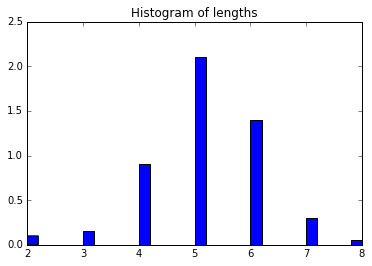

array([5, 7, 5, 5, 5, 6, 4, 6, 5, 4, 6, 5, 6, 7, 5, 5, 5, 5, 7, 5, 2, 5, 6,
       5, 6, 5, 7, 6, 6, 5, 4, 6, 3, 5, 6, 6, 5, 4, 5, 6, 6, 5, 3, 8, 5, 4,
       5, 5, 5, 4, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 7, 5, 5, 6, 3, 4, 6, 6, 4,
       5, 4, 6, 5, 6, 4, 4, 6, 5, 6, 4, 5, 2, 5, 4, 4, 6, 4, 4, 5, 6, 6, 4,
       5, 5, 6, 7, 6, 5, 4, 6])

In [70]:
generateLengths(100,5,1,True)

In [91]:
dictionary = generateDictionary(100)
dictionary [1:5]

array(['mgbbas', 'wgmowl', 'qarlmj', 'abvgr'], 
      dtype='<U7')

In [92]:
pickRandomWordsFromDict(dictionary,3,8,3)

['kszg', 'mgbbas', 'wgmowl']

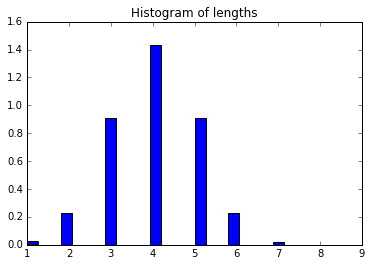

array(['kexic abvgr uawrlh', 'gsjzo syiht qzr lnxfo pusnf',
       'glvmt xezoq tofoe cezvzmf wlfwt', 'jjcth iarc frvru'], 
      dtype='<U55')

In [97]:
comments = generateComments(1000000,dictionary,4,1,True)
comments[1:5]

---
# Implimenting word search using string comparison (base line technique)

In [106]:
# Finds records that conatin specific words using numpy's string comparitor function

def findCommentsWithWords(comments,words):
    currentVocab = copy.deepcopy(comments)
    for w in words:
        currentVocab = currentVocab[(npstr.find(currentVocab, w) != -1)]
    return currentVocab

In [107]:
#Returns number of records that contain specific words

def numberOfMatches(comments, words):
    result = findCommentsWithWords(comments,words)
    return len(result)

### Test speed of finding number of records with specific words

In [99]:
randoWords =  pickRandomWordsFromDict(dictionary,3,8,2)
randoWords

['kszg', 'mgbbas']

In [103]:
start = time.time()
print(str(numberOfMatches(comments,randoWords)) + ' number of records found containing ' + str(randoWords))
end = time.time()
print(str(end - start)+' seconds')

1315 number of records found containing ['kszg', 'mgbbas']
1.1351401805877686 seconds


---
# Implimenting word indexing/search by prime factorisation

### Preprocessing/Indexing


In [128]:
# Assigns a prime number to each word in a given dictionary and returns a dict object 

def createIndexSchema(dictionary):
    primes = np.genfromtxt ('primes.csv', delimiter=",").astype(int)
    primeFit = primes[1:len(dictionary)+1,1]
    index = dict(np.c_[dictionary,primeFit])
    return index

In [129]:
# Converts a list of strings into the products of the words in the string's prime number indexes

def indexComments(comments,indexSchemal):
    output = []
    for comment in comments:
        prod = 1
        words = comment.split(' ')
        for word in words:
            if word in indexSchemal:
                prod *= int(indexSchemal[word])
        output.append(prod)
    return output

In [130]:
# Return the indexed dictionary and text data for a given normal dictionary of words and list of text data

def preprocessPrimeComments(dictionary,comments):
    indexSchemal = createIndexSchema(dictionary)
    indexedComments = indexComments(comments,indexSchemal)
    return [indexSchemal,indexedComments]

### Searching

In [131]:
# converts given words into their indexed product

def convertWordsToProduct(indexSchema, words):
    output = 1
    for word in words:
        output *= int(indexSchema[word])
    return output

In [132]:
# calculates the modulo of the indexed text data against the given search word product 
# and return a boolean list of which records match the search

def searchByPrimeFact(indexedComments,serachProduct):
    return  (np.mod(indexedComments, serachProduct) == 0)

In [136]:
# returns a boolean list of which of the given indexed records conatain 
# the given words using the given indexed dictionary

def findCommentsUsingPrimeFact(indexedComments,index, words):
    prod = convertWordsToProduct(index, words)
    return searchByPrimeFact(indexedComments,prod)

### Test speed of finding numberof records with specific words

In [137]:
[index, indexedComments] = preprocessPrimeComments(dictionary,comments)

In [152]:
start = time.time()
print(str(findCommentsUsingPrimeFact(indexedComments,index,randoWords).sum())+ ' number of records found containing ' + str(randoWords) )
end = time.time()
print(str(end - start)+' seconds')

1315 number of records found containing ['kszg', 'mgbbas']
0.15681910514831543 seconds


---
# Compare Performance
The different varibles that will be tested are: 

* Number of comments
* Number of query words
* Length of comments
* Dictionary length


In [153]:
# times the execution fo a function returning the seconds it took and the output of the function

def timeFunction(func, *params):
    start = time.time()
    output = func(*params)
    end = time.time()
    return[output, (end - start)]

In [154]:
# generate text records using the previously defined synthetic data function

def generateCommentData(dictLength, numOfComments, commentLengthMean, commentLengthDist, graph = False):
    random.seed(50)
    np.random.seed(15)
    dictionary = generateDictionary(dictLength)
    comments = generateComments(numOfComments,dictionary,commentLengthMean,commentLengthDist,graph)
    return [dictionary, comments]

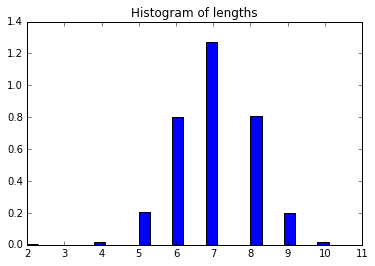

In [155]:
[d,c] = generateCommentData(300,100000,7,1, True)

## Performance against number of comments to search through

In [188]:
[d,c] = generateCommentData(300,100000,7,1, False)
wordsToserachFor = pickRandomWordsFromDict(d,3,7,3)
[indx,indxCom] = preprocessPrimeComments(d,c)

stringCompTimings1 = []
primeTimings1 = []
xIncrement1 = []
for n in range(100,100000,1000):
    xIncrement1.append(n)
    
    [o,t] = timeFunction(numberOfMatches, c[:n], wordsToserachFor)
    stringCompTimings1.append(t)
    
    [o,t] = timeFunction(findCommentsUsingPrimeFact, indxCom[:n],indx, wordsToserachFor)
    primeTimings1.append(t)

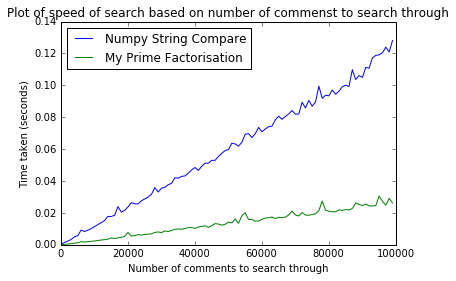

In [225]:
plt.figure()
plt.title("Plot of speed of search based on number of commenst to search through")
plt.ylabel("Time taken (seconds)")
plt.xlabel("Number of comments to search through")
strCompPlot, = plt.plot(xIncrement1,stringCompTimings1, label="Numpy String Compare")
primeFactPlot, = plt.plot(xIncrement1,primeTimings1, label="My Prime Factorisation")
plt.legend(handles=[strCompPlot,primeFactPlot],loc=2)
plt.show()

# Performance against number of words searched for

In [190]:
stringCompTimings2 = []
primeTimings2 = []
xIncrement2 = []
for n in range(1,100):
    xIncrement2.append(n)
    randWords2 = pickRandomWordsFromDict(d,2,7,n)
    
    [o,t] = timeFunction(numberOfMatches, c[:100000], randWords2)
    stringCompTimings2.append(t)
    
    [o,t] = timeFunction(findCommentsUsingPrimeFact, indxCom[:10000],indx, randWords)
    primeTimings2.append(t)

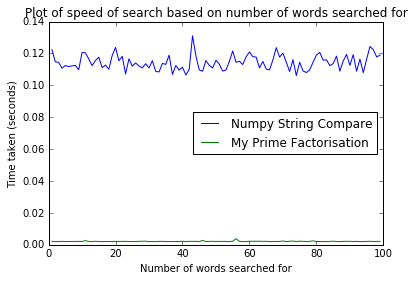

In [226]:
plt.figure()
plt.title("Plot of speed of search based on number of words searched for")
plt.ylabel("Time taken (seconds)")
plt.xlabel("Number of words searched for")
strCompPlot, = plt.plot(xIncrement2,stringCompTimings2, label="Numpy String Compare")
primeFactPlot, = plt.plot(xIncrement2,primeTimings2, label="My Prime Factorisation")
plt.legend(handles=[strCompPlot,primeFactPlot],loc=5)
plt.show()

# Performance against length of comments to search through

In [192]:
stringCompTimings3 = []
primeTimings3 = []
xIncrement3 = []
for n in range(5,500,10):
    xIncrement3.append(n)
    [d3,c3] = generateCommentData(30,1000,n,1)
    randWords3 = pickRandomWordsFromDict(d3,2,7,4)
    
    [o,t] = timeFunction(numberOfMatches, c3, randWords3)
    stringCompTimings3.append(t)
    
    [indexSchema3, indxCom3] = preprocessPrimeComments(d3,c3)
    [o,t] = timeFunction(findCommentsUsingPrimeFact, indxCom3,indexSchema3, randWords3)
    primeTimings3.append(t)

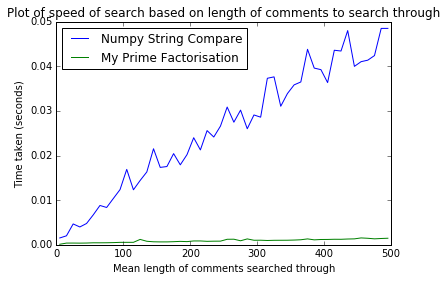

In [227]:
plt.figure()
plt.title("Plot of speed of search based on length of comments to search through")
plt.ylabel("Time taken (seconds)")
plt.xlabel("Mean length of comments searched through")
strCompPlot, = plt.plot(xIncrement3,stringCompTimings3, label="Numpy String Compare")
primeFactPlot, = plt.plot(xIncrement3,primeTimings3, label="My Prime Factorisation")
plt.legend(handles=[strCompPlot,primeFactPlot],loc=2)
plt.show()

# Performance against length of dictionary

In [219]:
stringCompTimings4 = []
primeTimings4 = []
xIncrement4 = []
for n in range(10,1000,10):
    xIncrement4.append(n)
    [d4,c4] = generateCommentData(n,2000,10,1)
    randWords4 = pickRandomWordsFromDict(d4,2,7,3)
    
    [o,t] = timeFunction(numberOfMatches, c4, randWords4)
    stringCompTimings4.append(t)
    
    [indexSchema4, indxCom4] = preprocessPrimeComments(d4,c4)
    [o,t] = timeFunction(findCommentsUsingPrimeFact, indxCom4,indexSchema4, randWords4)
    primeTimings4.append(t)

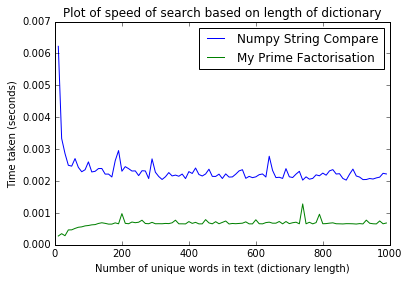

In [228]:
plt.figure()
plt.title("Plot of speed of search based on length of dictionary")
plt.ylabel("Time taken (seconds)")
plt.xlabel("Number of unique words in text (dictionary length)")
strCompPlot, = plt.plot(xIncrement4,stringCompTimings4, label="Numpy String Compare")
primeFactPlot, = plt.plot(xIncrement4,primeTimings4, label="My Prime Factorisation")
plt.legend(handles=[strCompPlot,primeFactPlot],loc=1)
plt.show()